In [41]:
from typing import Callable, Optional, Tuple
from fractions import Fraction

import functools
import torch
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
import pyro.contrib.gp as gp

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.robust.internals.utils import ParamDict
from chirho.robust.handlers.estimators import one_step_corrected_estimator 
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.predictive import PredictiveModel, PredictiveFunctional
from chirho.robust.internals.nmc import BatchedNMCLogMarginalLikelihood


pyro.settings.set(module_local_params=True)

sns.set_style("white")

pyro.set_rng_seed(32891) # for reproducibility

In [2]:
class CausalGLM(pyro.nn.PyroModule):
    def __init__(
        self,
        p: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        super().__init__()
        self.p = p
        self.link_fn = link_fn
        if prior_scale is None:
            self.prior_scale = 1 / math.sqrt(self.p)
        else:
            self.prior_scale = prior_scale

    def sample_outcome_weights(self):
        return pyro.sample(
            "outcome_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_intercept(self):
        return pyro.sample("intercept", dist.Normal(0.0, 1.0))

    def sample_propensity_weights(self):
        return pyro.sample(
            "propensity_weights",
            dist.Normal(0.0, self.prior_scale).expand((self.p,)).to_event(1),
        )

    def sample_treatment_weight(self):
        return pyro.sample("treatment_weight", dist.Normal(0.0, 1.0))

    def sample_covariate_loc_scale(self):
        return torch.zeros(self.p), torch.ones(self.p)

    def forward(self):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1))
        A = pyro.sample(
            "A",
            dist.Bernoulli(
                logits=torch.einsum("...i,...i->...", X, propensity_weights)
            ),
        )

        return pyro.sample(
            "Y",
            self.link_fn(
                torch.einsum("...i,...i->...", X, outcome_weights) + A * tau + intercept
            ),
        )

In [3]:
class ConditionedCausalGLM(CausalGLM):
    def __init__(
        self,
        X: torch.Tensor,
        A: torch.Tensor,
        Y: torch.Tensor,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        prior_scale: Optional[float] = None,
    ):
        p = X.shape[1]
        super().__init__(p, link_fn, prior_scale)
        self.X = X
        self.A = A
        self.Y = Y

    def forward(self):
        intercept = self.sample_intercept()
        outcome_weights = self.sample_outcome_weights()
        propensity_weights = self.sample_propensity_weights()
        tau = self.sample_treatment_weight()
        x_loc, x_scale = self.sample_covariate_loc_scale()
        with pyro.plate("__train__", size=self.X.shape[0], dim=-1):
            X = pyro.sample("X", dist.Normal(x_loc, x_scale).to_event(1), obs=self.X)
            A = pyro.sample(
                "A",
                dist.Bernoulli(
                    logits=torch.einsum("ni,i->n", self.X, propensity_weights)
                ),
                obs=self.A,
            )
            pyro.sample(
                "Y",
                self.link_fn(
                    torch.einsum("ni,i->n", X, outcome_weights)
                    + A * tau
                    + intercept
                ),
                obs=self.Y,
            )

In [4]:
class GroundTruthModel(CausalGLM):
    def __init__(
        self,
        p: int,
        alpha: int,
        beta: int,
        link_fn: Callable[..., dist.Distribution] = lambda mu: dist.Normal(mu, 1.0),
        treatment_weight: float = 0.0,
    ):
        super().__init__(p, link_fn)
        self.alpha = alpha  # sparsity of propensity weights
        self.beta = beta  # sparsity of outcome weights
        self.treatment_weight = treatment_weight

    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(self.beta) * torch.ones(self.p)
        outcome_weights[self.beta :] = 0.0
        return outcome_weights

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha :] = 0.0
        return propensity_weights

    def sample_treatment_weight(self):
        return torch.tensor(self.treatment_weight)

    def sample_intercept(self):
        return torch.tensor(0.0)

In [5]:
simulated_datasets = []

# Data configuration
alpha = 50
beta = 50
N_train = 500
N_test = 50
p_grid = [1, 10, 25, 50, 100, 150, 200, 250, 300, 500]

for p_dim in p_grid:
    true_model = GroundTruthModel(p_dim, alpha, beta)

    # Generate data
    D_train = Predictive(
        true_model, num_samples=N_train, return_sites=["X", "A", "Y"]
    )()
    D_test = Predictive(
        true_model, num_samples=N_test, return_sites=["X", "A", "Y"]
    )()
    simulated_datasets.append((D_train, D_test))

N_datasets = len(simulated_datasets)

In [6]:
fitted_params = []
model_fitting_time = []
for i in range(N_datasets):
    # Generate data
    D_train = simulated_datasets[i][0]

    start = time.time()
    # Fit model using maximum likelihood
    conditioned_model = ConditionedCausalGLM(
        X=D_train["X"], A=D_train["A"], Y=D_train["Y"]
    )
    
    guide_train = pyro.infer.autoguide.AutoDelta(conditioned_model)
    elbo = pyro.infer.Trace_ELBO()(conditioned_model, guide_train)

    # initialize parameters
    elbo()
    adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

    # Do gradient steps
    for _ in range(2000):
        adam.zero_grad()
        loss = elbo()
        loss.backward()
        adam.step()

    model_fitting_time.append(time.time() - start)

    theta_hat = {
        k: v.clone().detach().requires_grad_(True) for k, v in guide_train().items()
    }
    fitted_params.append(theta_hat)

In [7]:
class ATEFunctional(torch.nn.Module):
    def __init__(self, model: Callable, *, num_monte_carlo: int = 100):
        super().__init__()
        self.model = model
        self.num_monte_carlo = num_monte_carlo
    
    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(A=(torch.tensor(0.0), torch.tensor(1.0)))):
                    Ys = self.model(*args, **kwargs)
                Y0 = gather(Ys, IndexSet(A={1}), event_dim=0)
                Y1 = gather(Ys, IndexSet(A={2}), event_dim=0)
        ate = (Y1 - Y0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        return pyro.deterministic("ATE", ate)
    
# Closed form expression
def closed_form_doubly_robust_ate_correction(X_test, theta) -> Tuple[torch.Tensor, torch.Tensor]:
    X = X_test["X"]
    A = X_test["A"]
    Y = X_test["Y"]
    pi_X = torch.sigmoid(X.mv(theta["propensity_weights"]))
    mu_X = (
        X.mv(theta["outcome_weights"])
        + A * theta["treatment_weight"]
        + theta["intercept"]
    )
    analytic_eif_at_test_pts = (A / pi_X - (1 - A) / (1 - pi_X)) * (Y - mu_X)
    analytic_correction = analytic_eif_at_test_pts.mean()
    return analytic_correction, analytic_eif_at_test_pts

# Helper class to create a trivial guide that returns the maximum likelihood estimate
class MLEGuide(torch.nn.Module):
    def __init__(self, mle_est: ParamDict):
        super().__init__()
        self.names = list(mle_est.keys())
        for name, value in mle_est.items():
            setattr(self, name + "_param", torch.nn.Parameter(value))

    def forward(self, *args, **kwargs):
        for name in self.names:
            value = getattr(self, name + "_param")
            pyro.sample(
                name, pyro.distributions.Delta(value, event_dim=len(value.shape))
            )

# Compute doubly robust ATE estimates using both the automated and closed form expressions
plug_in_ates = []
analytic_corrections = []
automated_monte_carlo_corrections = []
automated_monte_carlo_at_test = []
automated_monte_carlo_time = []
analytic_at_test = []
for i, p in enumerate(p_grid):
    print(p)
    theta_hat = fitted_params[i]
    D_test = simulated_datasets[i][1]
    mle_guide = MLEGuide(theta_hat)
    functional = functools.partial(ATEFunctional, num_monte_carlo=10000)
    ate_plug_in = functional(
        PredictiveModel(CausalGLM(p), mle_guide)
    )()
    analytic_correction, analytic_eif_at_test_pts = closed_form_doubly_robust_ate_correction(D_test, theta_hat)

    start = time.time()
    monte_eif = influence_fn(functional, D_test, num_samples_outer=10000, num_samples_inner=1)
    monte_eif_at_test_pts = monte_eif(PredictiveModel(CausalGLM(p), mle_guide))()
    end = time.time()
    automated_monte_carlo_time.append(end - start)
    automated_monte_carlo_at_test.append(monte_eif_at_test_pts)
    analytic_at_test.append(analytic_eif_at_test_pts)

    plug_in_ates.append(ate_plug_in.detach().item())
    analytic_corrections.append(ate_plug_in.detach().item() + analytic_correction.detach().item())


1
10
25
50
100
150
200
250
300
500


In [8]:
def median_rel_error(x, y):
    x = torch.tensor(x)
    y = torch.tensor(y)
    return torch.median(torch.abs(x - y) / torch.abs(y))

In [9]:
monte_eif_errors = [median_rel_error(monte_eif_at_test_pts, analytic_eif_at_test_pts) for monte_eif_at_test_pts, analytic_eif_at_test_pts in zip(automated_monte_carlo_at_test, analytic_at_test)]

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_55710/3392044420.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_55710/3392044420.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


In [10]:
model_dimension_grid = [sum([v.numel() for k, v in param.items()]) for param in fitted_params]

In [51]:
Fraction(int(round(8*obs_slope)),8).numerator

3

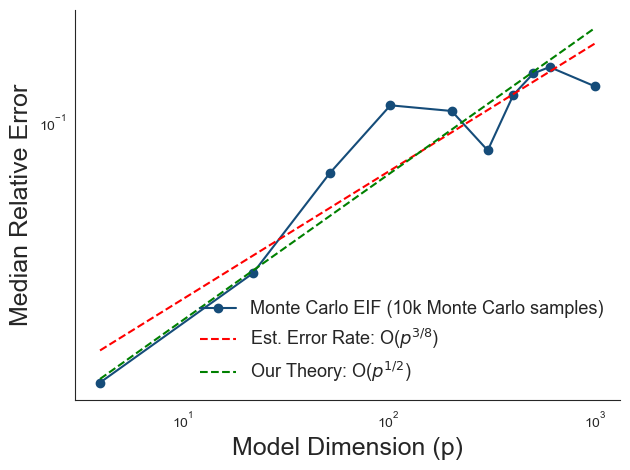

In [64]:
obs_slope, obs_intercept = np.polyfit(
    np.log10(model_dimension_grid), 
    np.log10(monte_eif_errors), 1)

theory_slope = 1/2
theory_intercept = (np.log10(monte_eif_errors) - theory_slope * np.log10(model_dimension_grid)).mean()

# Plot results
plt.plot(
    model_dimension_grid, 
    monte_eif_errors, 
    label='Monte Carlo EIF (10k Monte Carlo samples)', 
    color='#154c79',
    marker='o'
)
obs_rate_num = Fraction(int(round(8*obs_slope)),8).numerator
obs_rate_denom = Fraction(int(round(8*obs_slope)),8).denominator
plt.plot(model_dimension_grid, 
    10**obs_intercept * np.power(model_dimension_grid, obs_slope), 
    label='Est. Error Rate: O($p^{3/8}$)',
    color='red',
    linestyle='--'
)
plt.plot(model_dimension_grid, 
    10**theory_intercept * np.power(model_dimension_grid, theory_slope), 
    label='Our Theory: O($p^{1/2}$)',
    color='green',
    linestyle='--'
)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Median Relative Error', fontsize=18)
plt.xlabel('Model Dimension (p)', fontsize=18)
sns.despine()
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.savefig('./figures/error_rate_causal_glm_vs_dim.png')

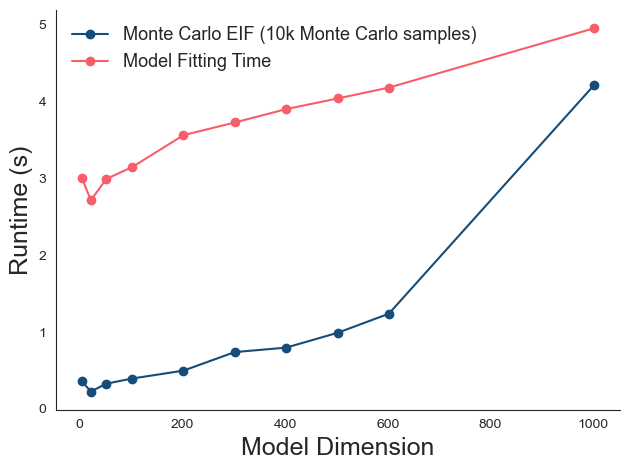

In [66]:
# Plot results
plt.plot(
    model_dimension_grid, 
    automated_monte_carlo_time, 
    label='Monte Carlo EIF (10k Monte Carlo samples)', 
    color='#154c79',
    marker='o'
)
plt.plot(
    model_dimension_grid, 
    model_fitting_time, 
    label='Model Fitting Time', 
    color='#f95d6a',
    marker='o'

)
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Runtime (s)', fontsize=18)
plt.xlabel('Model Dimension', fontsize=18)
sns.despine()
plt.legend(fontsize=13, frameon=False)
plt.tight_layout()
plt.savefig('./figures/runtime_causal_glm_vs_dim.png')